In [1]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
import jax.nn as nn
from jax.experimental import optimizers, stax
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import imageio
# from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm
import numpy as onp
import pdb
from PIL import Image
from jax.nn.initializers import glorot_normal, normal, ones, zeros
import functools

def constant(constant, dtype=np.float32):
    def init(key, shape, dtype=dtype):
        return np.ones(shape, dtype) * constant
    return init

def output_layer():
    init_fun = lambda rng, input_shape: (input_shape, ())
    def apply_fun(params, inputs, **kwargs):
#         outputs = np.stack([jax.nn.softplus(inputs[..., 0]), jax.nn.sigmoid(inputs[..., 1]) * np.pi*2], -1)
        mag = nn.softplus(inputs[..., 0])
#         mag = np.exp(inputs[..., 0])
#         phasor = nn.sigmoid(inputs[..., 1])*np.pi*2 - np.pi
#         outputs = mag * np.cos(phasor) + 1j *mag * np.sin(phasor)
        outputs = inputs[..., 0] + 1j * inputs[..., 1]
        return outputs
    
    return init_fun, apply_fun
    

def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(2))
    layers.append(output_layer())
    return stax.serial(*layers)

model_loss = jit(lambda params, x, y: .5 * np.mean((apply_fn(params, x) - y) ** 2))

model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))
input_encoder = jit(lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                    a * np.cos((2.*np.pi*x) @ b.T)], axis=-1))

def train_model(lr, iters, train_data, test_data, name='test', plot_groups=None):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    train_loss = []
    test_loss = []
    xs = []
    if plot_groups is not None:
        plot_groups['Test PSNR'].append(f'{name}_test')
        plot_groups['Train PSNR'].append(f'{name}_train')
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            train_loss.append(model_loss(get_params(opt_state), *train_data))
            test_loss.append(model_loss(get_params(opt_state), *test_data))
            xs.append(i)
            if plot_groups is not None:
                plotlosses_model.update({f'{name}_train':train_psnr, f'{name}_test':test_psnr}, current_step=i)
        if i % 100 == 0 and i != 0 and plot_groups is not None:
            plotlosses_model.send()
    if plot_groups is not None:
        plotlosses_model.send()
    results = {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'xs': xs
    }
    return results

In [2]:
## Random seed
def plot(R):
    clim = np.quantile(np.abs(R.reshape(-1)), np.array([.01, .99]))
    plt.imshow(np.abs(R), vmin=clim[0], vmax=clim[1], cmap='jet')
    plt.colorbar()

rand_key = random.PRNGKey(10)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
data = np.array(Image.open('MRI.bmp'))[..., None] / 255
def FFT2(inputs):
    raw_fft = np.fft.fft2(inputs.reshape(inputs.shape[:2]))  
    phasor = np.angle(raw_fft) + np.pi
    mag = np.abs(raw_fft) / np.abs(raw_fft).max()
    return np.stack([mag, phasor], axis=-1)

def IFFT2(inputs):
    mag = inputs[..., 0]
    phasor = inputs[..., 1] - np.pi
    raw_fft = mag * np.cos(phasor) + 1j *mag * np.sin(phasor)
    raw_fft = raw_fft[..., None]
    return np.fft.ifft2(raw_fft)

def IFFT(inputs):
    mag = inputs[..., 0]
    phasor = inputs[..., 1] - np.pi
    raw_fft = mag * np.cos(phasor) + 1j *mag * np.sin(phasor)
    raw_fft = raw_fft[..., None]
    return np.fft.ifft(raw_fft, axis=1)

def FFT(inputs):
    raw_fft = np.fft.fft(inputs, axis=1)
    phasor = np.angle(raw_fft) + np.pi
    mag = np.abs(raw_fft)
    return np.concatenate([mag, phasor], axis=-1)

## data processing 

In [3]:
def radon_transform(im, angles):
    width, height = onp.array(im).shape
    diag = onp.sqrt(width**2 + height**2)
    width_pad = int(diag-width)+2;
    height_pad = int(diag-height)+2;
    padimg = onp.zeros((width+width_pad, height+height_pad))
    padimg[int(width_pad/2):-int(width_pad/2), int(height_pad/2):-int(height_pad/2)] = im
    padimg = Image.fromarray(padimg)
    radon = onp.stack([np.array(padimg.rotate(ang)).sum(0) for ang in angles], axis=-1)
    radon = radon[int(width_pad/2):-int(width_pad/2), :]
    return radon.transpose()

import scipy.interpolate as intp
def fourier_map(proj, angles, intp_method='bilinear'):
    """
        proj: (A, N)
        angles: (A, )
    """
    # align the data to origin
    P_fx = np.fft.fft(proj, axis=-1)
    ang = (angles.reshape(-1,1))
    fx = np.fft.fftfreq(len(proj[0]))
    fx = fx.reshape(1,-1)
    fxl = (fx) * np.cos(np.deg2rad(ang))
    fyl = (fx) * np.sin(np.deg2rad(ang))
    Xf = fxl.flatten()
    Yf = fyl.flatten()
    Zf = P_fx.flatten()
    rintp = fx.reshape(-1)
    Fcomp = intp.griddata((Xf, Yf), Zf, (rintp[None, :], rintp[:, None]), fill_value=0)
    f =np.fft.fftshift(np.fft.ifft2(Fcomp))
    return f, Fcomp

angles = onp.linspace(0, 180, 100)
radon = radon_transform(data[..., 0], angles)
radon = np.fft.ifftshift(radon, axes=-1)
P_fx = np.fft.fft(radon/radon.max(), axis=-1)
Fx = np.fft.ifft(P_fx, axis=-1)
plt.imshow(np.abs(np.sin(np.angle(Fx))), cmap='jet')
plt.colorbar()
f, Fcomp = fourier_map(radon[::2]/radon.max(), angles[::2])
# plt.plot(Fcomp)
# plot(np.abs((fourier_map(radon[::16]/radon.max(), angles[::16]))))
# np.angle(P_fx).min()
# GTP_fx = P_fx
plt.close()
plt.imshow(np.clip(np.fft.fftshift(np.log(np.abs(Fcomp))), -6, np.inf), cmap='jet')
plt.colorbar()

RuntimeError: Internal: Unable to launch fft for thunk 0x7fb7dfd8c610 with type IFFT

# training 

In [4]:
network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  4000#@param
test_scales =  [13,14,15]#@param
embedding_size =  256#@param
init_fn, apply_fn = make_network(network_depth, network_width)



In [5]:
angles.shape, radon.shape
radon = radon / radon.max()

# upsampling
int1d = intp.interp1d(np.arange(radon.shape[1]), radon, axis=1, fill_value='extrapolate')
scale = 1
train_data = int1d(np.arange(radon.shape[1]*scale)/scale)
fx = np.fft.fftfreq(radon.shape[1] * scale) * scale
fx = fx.reshape(1,-1)
fxl = (fx) * np.cos(np.deg2rad(angles[..., None]))
fyl = (fx) * np.sin(np.deg2rad(angles[..., None]))
rintp = np.stack(np.meshgrid(fx.reshape(-1), fx.reshape(-1)), -1)


x_t = np.stack([fxl, fyl], axis=-1)
x_train = x_t[::2]
x_test = x_t[1::2]
y_train = train_data[::2, :, None]
y_test = train_data[1::2, :, None]
bvals = random.normal(rand_key, (embedding_size, 2))
avals = np.ones((bvals.shape[0]))
scale = 30


def encoder(x, min_deg, max_deg):
    rho = np.sqrt(x[..., 0]**2+x[..., 1]**2) * np.pi
    theta = np.arctan2(x[..., 1], x[..., 0])
    xs = [rho, theta]
    def enc(x, min_deg, max_deg):
        scales = np.array([i for i in range(min_deg, 2**max_deg)]).reshape(1,1,-1)
        xb = x[..., None] * scales
        four_feat = np.sin(np.concatenate([xb, xb + 0.5 * np.pi], axis=-1))
        return np.concatenate([four_feat], axis=-1)
    enc(xs[0], min_deg[0], max_deg[0]).shape
    y = np.concatenate([enc(x, mind, maxd) for x, mind, maxd in zip(xs, min_deg, max_deg)], axis=-1)
    return y

def encoder2(x, avals, bvals):
    rho = np.sqrt(x[..., 0]**2+x[..., 1]**2)[..., None]
    theta = np.arctan2(x[..., 1], x[..., 0])[..., None]
    ux = np.cos(theta)
    uy = np.sin(theta)
    us = np.concatenate([ux, uy], axis=-1)
    xs = [rho, theta]
    input_encoder = jit(lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                    a * np.cos((2.*np.pi*x) @ b.T)], axis=-1))
    y = np.concatenate([input_encoder(x, a, b) for x, a, b in zip(xs, avals, bvals)], axis=-1)
    return y

# rho = np.sqrt(x[..., 0]**2+x[..., 1]**2)[..., None]
# pos_enc = functools.partial(encoder2, avals=(np.ones((embedding_size)), np.ones((embedding_size))), bvals=(random.normal(rand_key, (embedding_size, 1)), random.normal(rand_key, (embedding_size, 2))))
# pos_enc = functools.partial(encoder, min_deg=(), max_deg=(,))

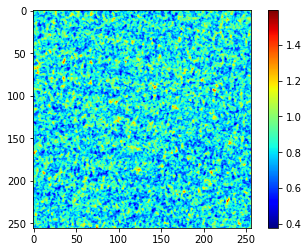

In [6]:
pos_enc = functools.partial(input_encoder, a=avals, b=bvals*scale)
# pos_enc = functools.partial(encoder, min_deg=(0,0), max_deg=(5,3))
bvals=(random.normal(rand_key, (embedding_size//2, 1)), random.normal(rand_key, (embedding_size//2, 1)))
bvals = (bvals[0]*100, bvals[1]*100)
avals=(np.ones((embedding_size//2)), np.ones((embedding_size//2)))
# pos_enc = functools.partial(encoder2, avals=avals, bvals=bvals)
# x_train
train_data = (pos_enc(x_train), y_train)
test_data = (pos_enc(x_test), y_test)
# initialization visulization
_, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
rintp = np.stack(np.meshgrid(fx.reshape(-1), fx.reshape(-1)), -1)
inputs = pos_enc(rintp)
plt.imshow(np.abs(np.fft.fftshift(apply_fn(params, inputs))), cmap='jet')
plt.colorbar()

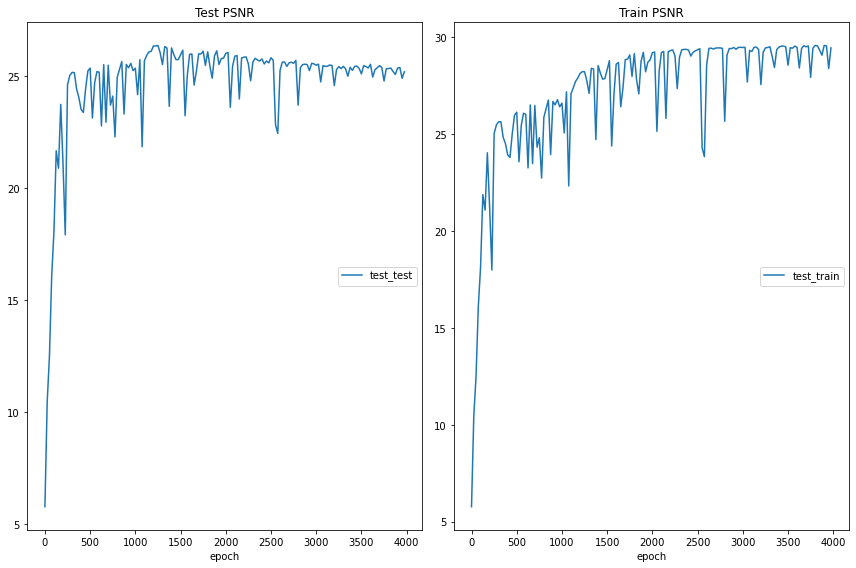

Test PSNR
	test_test        	 (min:    5.768, max:   26.371, cur:   25.197)
Train PSNR
	test_train       	 (min:    5.767, max:   29.586, cur:   29.463)


In [7]:
plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

def model_loss(params, x, y):
    loss = .5 * np.mean(np.abs((np.fft.ifft(apply_fn(params, x), axis=1)) - y) ** 2)
    return loss

results = train_model(lr, training_steps, train_data, test_data, name='test', plot_groups=plt_groups)

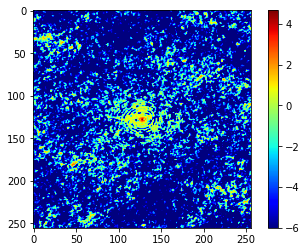

In [8]:
# plot(fourier_map(np.abs(test_output[..., 0]), angles[1::2]))
test_input = onp.array(train_data[0])
P_out = apply_fn(results['state'], test_input)[..., 0]
test_output = np.fft.ifft(P_out, axis=-1)
# proj = np.abs(test_output)
# P_fx = np.fft.fft(proj, axis=-1)
P_fx = P_out
ang = (angles[::2]).reshape(-1,1)
fx = np.fft.fftfreq(len(P_fx[0]))
fx = fx.reshape(1,-1)
fxl = (fx) * np.cos(np.deg2rad(ang))
fyl = (fx) * np.sin(np.deg2rad(ang))
Xf = fxl.flatten()
Yf = fyl.flatten()
Zf = P_fx.flatten()
rintp = fx.reshape(-1)
rintp = np.stack(np.meshgrid(fx.reshape(-1), fx.reshape(-1)), -1)
Fcomp = intp.griddata((Xf, Yf), Zf, (rintp), fill_value=0)
# f = np.fft.fftshift(np.fft.ifft2((Fcomp)))
# plot(np.abs(test_output))
inputs = pos_enc(rintp)
# inputs = input_encoder(rintp, avals, bvals*scale)
Fcomp2 = apply_fn(results['state'], inputs)[..., 0]
Fcomp2 = onp.fft.fftshift(onp.array(Fcomp2))
mask = 0
if mask > 1:
    Fcomp2[:mask,] = 0
    Fcomp2[-mask:,] = 0
    Fcomp2[:, :mask] = 0
    Fcomp2[:, -mask:] = 0
# plt.imshow(Fcomp2==0)
# plt.imshow(np.abs(Fcomp2), cmap='jet')
# plt.colorbar()
# plt.imshow(np.abs(Fcomp2 - np.fft.fftshift(Fcomp)), cmap='jet')
# plt.colorbar()

f = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Fcomp2)))
# plt.gray()
plot(np.abs(f))
# plt.imshow(np.abs(f), cmap='jet')
# plt.imshow(np.abs((Fcomp2)), cmap='jet')
# plt.colorbar()
# np.fft.fftshift(Fcomp2)[0, 0], Fcomp2[0, 0]
# plt.imshow(np.log(np.abs(Fcomp2)), cmap='jet')
# plt.colorbar()
# plt.close()
plt.close()
plt.imshow(np.clip(np.log(np.abs(Fcomp2)), -6, np.inf), cmap='jet')
plt.colorbar()
# P_out

In [9]:
# np.fft.fftfreq(10) * 10
# np.fft.fftfreq(200) * 200

In [10]:
# 